In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
from datagen import ImageDataGenerator, SequenceDataGenerator

In [33]:
deeplab = deeplabv3(pretrained=True, progress=True)

In [41]:
list(deeplab.children())[-1]

FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1)
  (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
)

In [42]:
deeplab

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(


In [20]:
dg = SequenceDataGenerator(num_shape = 3, image_size = 128, sequence_len = 20)

In [23]:
class SequenceDataGenerator:
    def __init__(self, num_shape, image_size, sequence_len):
        self.num_shape = num_shape
        self.image_size = image_size
        self.sequence_len = sequence_len
        self.shapes = None

    def init_shapes(self):
        shape_choices = [1, 2, 3]
        shape_types = np.random.choice(
            shape_choices, size=(self.num_shape), replace=True)
        self.shapes = get_shapes(shape_types, self.image_size)

    def get_velocities(self):
        self.velocities = np.random.randint(
            low=int(-0.1 * self.image_size), high=int(0.1 * self.image_size), size=(self.num_shape, 2))

    def move(self):
        for i in range(self.num_shape):
            velocity = self.velocities[i]
            dx, dy = velocity
            shape_info = self.shapes[i]
            shape_info['offset'] += velocity
            if shape_info['type'] == 'round':
                shape_info['x1'] += dx
                shape_info['y1'] += dy
            else:
                shape_info['corners'] += velocity

    def bounce(self):
        for i in range(self.num_shape):
            dx, dy = self.velocities[i]
            shape_info = self.shapes[i]
            if shape_info['type'] == 'round':
                x1, y1 = shape_info['x1'], shape_info['y1']
                if x1 < 0 or x1 > self.image_size:
                    dx = -dx
                    print(x1, dx)
                if y1 < 0 or y1 > self.image_size:
                    dy = -dy
                    print(y1, dy)
            else:
                corners = shape_info['corners']
                x_min = np.min(corners[:, 0])
                x_max = np.max(corners[:, 0])
                y_min = np.min(corners[:, 1])
                y_max = np.max(corners[:, 1])
                if x_min < 0 or x_max > self.image_size:
                    dx = -dx
                if y_min < 0 or y_max > self.image_size:
                    dy = -dy
            self.velocities[i] = [dx, dy]

    def render_frame(self):
        image_info = get_image_from_shapes(self.shapes, self.image_size)
        return image_info

    def render_sequence(self):
        sequence = []
        self.get_velocities()
        for _ in range(self.sequence_len):
            self.move()
            self.bounce()
            image_info = self.render_frame()
            sequence.append(image_info)
        return sequence

    def get_sequence(self):
        self.init_shapes()
        sequence = self.render_sequence()
        return sequence

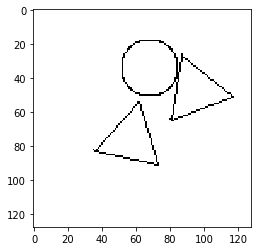

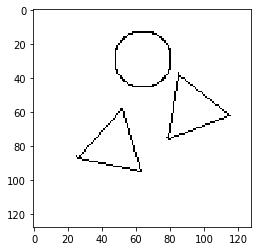

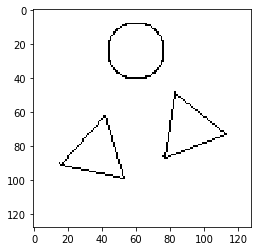

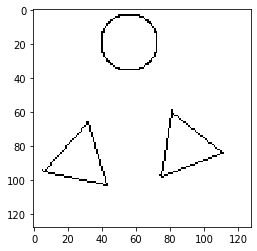

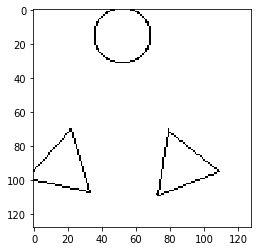

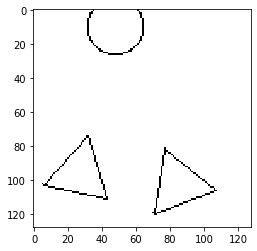

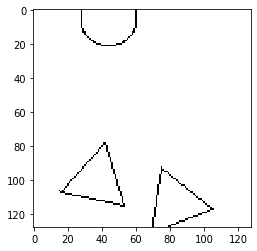

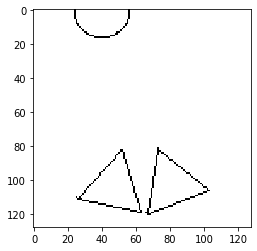

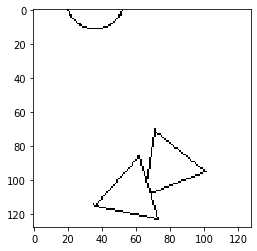

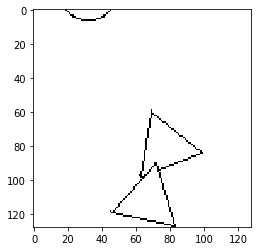

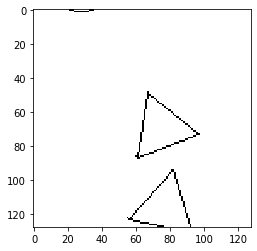

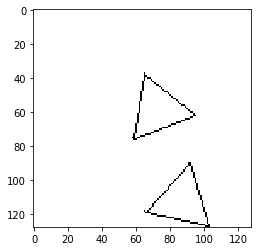

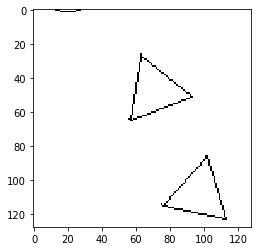

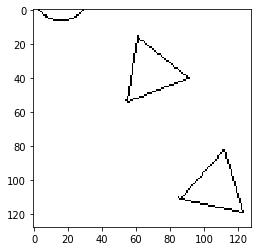

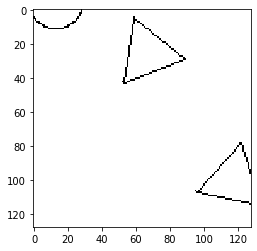

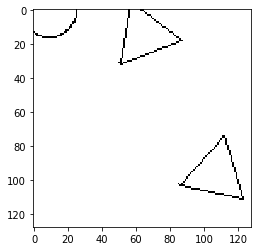

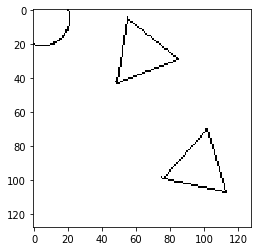

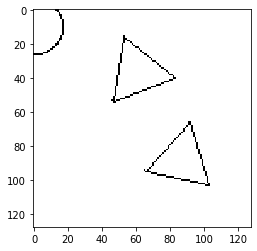

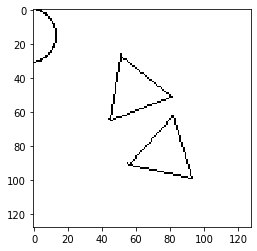

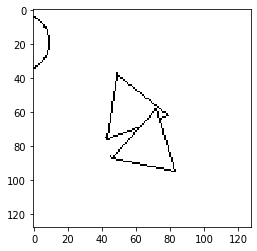

In [26]:
sequence = dg.get_sequence()
for image_info in sequence:
    plt.figure()
    plt.imshow(image_info['image'])